# Polar Distance Computation 

This notebook presents an algorithm to compute distances between cells in polar coordinates. 

## Defining Required Functions 

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import pandas as pd
from scipy import interpolate
from scipy.signal import  butter, filtfilt


coord_transfer function computes appropriate [center_shift_x , center_shift_y] valuse so that the origin is shifted to the mean of all coordinates and rotatation theta theta_shift so that theta values are continuous between 0 and 2*pi.

In [2]:
def coord_transfer(xcoords, ycoords):
    center_shift_x=np.mean(xcoords)
    center_shift_y=np.mean(ycoords)

    xcoords=xcoords-center_shift_x
    ycoords=ycoords-center_shift_y

    xcoordspi=xcoords>0
    xcoordsni=xcoords<0

    posi=np.argmax(xcoords[xcoordspi]**2+ycoords[xcoordspi]**2)
    negi=np.argmax(xcoords[xcoordsni]**2+ycoords[xcoordsni]**2)


    ymax=ycoords[xcoordspi][posi]
    ymin=ycoords[xcoordsni][negi]
    xmax=xcoords[xcoordspi][posi]
    xmin=xcoords[xcoordsni][negi]

    slope=(ymax-ymin)/(xmax-xmin)
    theta=np.arctan(slope)

    #rotatet the frame so that  first theta does not start from zero, and hence becomes continous
    theta_shift=theta-np.pi/2  
    return [center_shift_x , center_shift_y], theta_shift

coord_translate function translates the input custom coordinates with the valuse obtained by coord_transfer. We actually don't need this function if we intend to compute minimum distances and use shuffling to generate random data. Hovever, this funtion is needed when we use theta bins to compute  joint probability distribution. 

In [3]:

def coord_translate(x, y, shift=0, rtheta=0):
    ##  Parameters:
    
        # xcoords   : array_like Input data X Cartesian Coordinates. 
        # ycoords   : array_like Input data Y Cartesian Coordinates. 

    ##  Returns:
    
        # [center_shift_x , center_shift_y]: The values of the proper coordinate shifts 
        #                                    so that origin is located in the center of the mass.

        # theta_shift  : The value of required rotation so the theta values are continuous.
    
    xo=x-shift[0]
    yo=y-shift[1]

    xr=(np.cos(rtheta)*xo+np.sin(rtheta)*yo)
    yr=(np.cos(rtheta)*yo-np.sin(rtheta)*xo)
    tvalo=np.mod(np.arctan2(yr, xr), 2*np.pi)
    idx_sorted=np.argsort(tvalo)
    tvalo=tvalo[idx_sorted]
    rvalo=np.sqrt(yr**2+xr**2)
    rvalo=rvalo[idx_sorted]

    xsro=xr[idx_sorted]
    ysro=yr[idx_sorted]

    return xsro, ysro, rvalo, tvalo

lp_filter function applies a butterworth lowpass filter on the input data. 

In [4]:
def lp_filter(radius, BW=0.1):
    
    ##  Parameters:
    
        # radius   : array_like Input data ,  radius Coordinates. 
        # BW       : cutoff frequency of the lowpass filter

    ##  Returns:
    
        # filtered_r: low pass filtered radius values
        

        
    # Create a lowpass butterworth filter and apply it to r.

    b,a=butter(5, BW, fs=1, btype='low', analog=False)


    filtered_r = filtfilt(b, a, radius)

    return filtered_r

rdistance_vec function computes distance of all point from the first input point in polar coordinates. The distances are computed by $ds=\sum \sqrt{(\delta r)^2 + (r \times \delta t)^2}$

In [5]:
def rdistance_vec(radius, theta):
    ##  Parameters:
    
        # radius   : array_like  radius Coordinates. 
        # theta    : array_like  theta Coordinates. 

    ##  Returns:
    
        # distvec : array_like distances from the first point
    dr=radius[1:]-radius[:-1]
    dt=theta[1:]-theta[:-1]
    rdt=radius[1:]*dt
    distd=np.sqrt(dr**2+rdt**2)
    distvec=np.cumsum(distd)
    return distvec

## Reading and Translating Input Data 

Reading and plotting RetinaNumber=1, and SectioNumber=1 cell locations. 

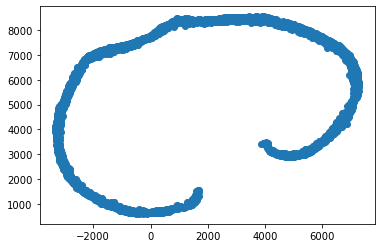

In [6]:
xy_table=pd.read_csv('data/Retina1.csv')
xy_r11=xy_table[(xy_table.RetinaNumber==1) & (xy_table.SectionNumber==1)]
xcoords=xy_r11.Remapped_X.values
ycoords=xy_r11.Remapped_Y.values
plt.figure()
plt.scatter(xcoords, ycoords)

Computing appropriate shift and rotate values and applying them on the input coordinates. 

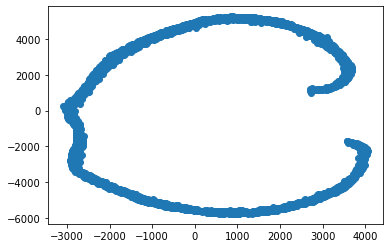

In [7]:
center_shift, theta_shift=coord_transfer(xcoords, ycoords)
center_shift_x=center_shift[0]
center_shift_y=center_shift[1]
xcoords=xcoords-center_shift_x
ycoords=ycoords-center_shift_y
xcoords_rot=(np.cos(theta_shift)*xcoords+np.sin(theta_shift)*ycoords)
ycoords_rot=(np.cos(theta_shift)*ycoords-np.sin(theta_shift)*xcoords)
plt.figure()
plt.scatter(xcoords_rot, ycoords_rot)

## Regressing Out the Relationship Between Radius and Theta

Computing polar coordinates of the input data, and sorting them based on their theta values.

In [8]:
tvalo=np.mod(np.arctan2(ycoords_rot, xcoords_rot), 2*np.pi)
sidx=np.argsort(tvalo)
tvalo=tvalo[sidx]
rvalo=np.sqrt(ycoords_rot**2+xcoords_rot**2)
rvalo=rvalo[sidx]
ycoords_rot, xcoords_rot=ycoords_rot[sidx], xcoords_rot[sidx]


Suppose that cells are distributed along a strip. We aim to straighten this strip so that we can compute distances. In order to do that, we should find a thread along which radius, and theta values are distributed. We start by straightening the knees at the start and the end of the strip, so that the final thread curve is smooth enough. We unbend the knees untill there is no knee. 

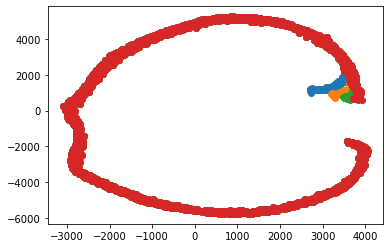

In [9]:
plt.figure()
plt.scatter(xcoords_rot, ycoords_rot)
rval_crt=np.argmax(xcoords_rot[tvalo<np.pi])
#rval_crt_thr=rval_crt-1
rval_crt_thr=5
while(rval_crt>rval_crt_thr):

    xt=(xcoords_rot[:rval_crt]-xcoords_rot[rval_crt])
    yt=(ycoords_rot[:rval_crt]-ycoords_rot[rval_crt])
    theta_mod=-np.pi/8
    xcoords_rot[:rval_crt]=xt*np.cos(theta_mod)+yt*np.sin(theta_mod)+xcoords_rot[rval_crt]
    ycoords_rot[:rval_crt]=yt*np.cos(theta_mod)-xt*np.sin(theta_mod)+ycoords_rot[rval_crt]
    tvalo=np.mod(np.arctan2(ycoords_rot, xcoords_rot), 2*np.pi)
    sidx=np.argsort(tvalo)
    tvalo=tvalo[sidx]
    rvalo=np.sqrt(ycoords_rot**2+xcoords_rot**2)
    rvalo=rvalo[sidx]
    ycoords_rot, xcoords_rot=ycoords_rot[sidx], xcoords_rot[sidx]
    rval_crt=np.argmax(xcoords_rot[tvalo<np.pi/2])
    plt.scatter(xcoords_rot, ycoords_rot)

Straightening the end part of the cell locations' strip.

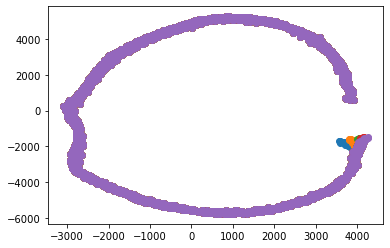

In [10]:
rval_crt=np.argmax(xcoords_rot[tvalo>np.pi])
rval_crt=len(xcoords_rot[tvalo<np.pi])+rval_crt
xlen=len(xcoords_rot)
rval_crt_thr=xlen-5
#rval_crt_thr=rval_crt
plt.figure()
plt.scatter(xcoords_rot, ycoords_rot)
while(rval_crt< rval_crt_thr):

    xt=(xcoords_rot[rval_crt:]-xcoords_rot[rval_crt])
    yt=(ycoords_rot[rval_crt:]-ycoords_rot[rval_crt])
    theta_mod=np.pi/8
    xcoords_rot[rval_crt:]=xt*np.cos(theta_mod)+yt*np.sin(theta_mod)+xcoords_rot[rval_crt]
    ycoords_rot[rval_crt:]=yt*np.cos(theta_mod)-xt*np.sin(theta_mod)+ycoords_rot[rval_crt]
    tvalo=np.mod(np.arctan2(ycoords_rot, xcoords_rot), 2*np.pi)
    sidx=np.argsort(tvalo)
    tvalo=tvalo[sidx]
    rvalo=np.sqrt(ycoords_rot**2+xcoords_rot**2)
    rvalo=rvalo[sidx]
    ycoords_rot, xcoords_rot=ycoords_rot[sidx], xcoords_rot[sidx]
    rval_crt=np.argmax(xcoords_rot[tvalo>np.pi])
    rval_crt=len(xcoords_rot[tvalo<np.pi])+rval_crt

    plt.scatter(xcoords_rot, ycoords_rot)

Computing a smooth curve between radius and theta values by passing real straightened radius and theta values through a low pass filter.  

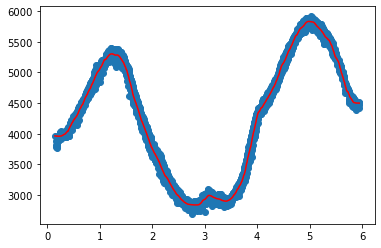

In [11]:

rvalo_filtered=lp_filter(rvalo-rvalo[0], BW=0.01)+rvalo[0]

plt.figure()
plt.scatter(tvalo, rvalo)
plt.plot(tvalo, rvalo_filtered, color='red')

The estimated curve of x, y coordinates can also be plotted along with the real ones.

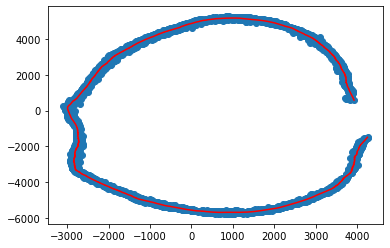

In [12]:
xcoords_lp=rvalo_filtered*np.cos(tvalo)
ycoords_lp=rvalo_filtered*np.sin(tvalo)

plt.figure()
plt.scatter(xcoords_rot, ycoords_rot)
plt.plot(xcoords_lp, ycoords_lp,color='red')



Distances of all points from the fisrt starting point are computed here on the curve obtained above between r, and theta values. 

In [13]:
dis_vec=rdistance_vec(rvalo_filtered, tvalo)
dis_vec=np.append(0, dis_vec)

Regressing out the relationship between r, and theta by substracting filtered r values from real ones. 

In [14]:
r_regout=rvalo-rvalo_filtered


(dis_vec, r_regout) are new straightened cartesian values of the cell locations. The distances now can be computed by the ususal cartezain distance between (dis_vec, r_regout) values. 

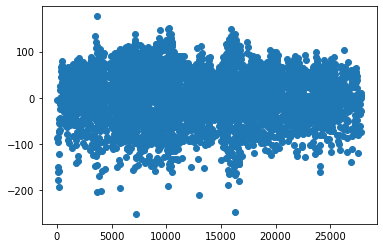

In [15]:
plt.figure()
plt.scatter(dis_vec, r_regout)

## Verifying the Algorithm

We generate test data to evalute if our algorithm works properly. The test data is the noisy values of the curve,  $r=1000\times sin(\theta)$. This curve is easy to compute distances, and the distance between two points is $1000 \times \Delta \theta$, where  $\Delta \theta$ is their phase difference. Therefore, we expect the final distances to be noisy values between $0$ and $1000* (\pi-\pi/8)=2749$

In [16]:
t_test=np.linspace(np.pi/16, np.pi-np.pi/16, 2000)+np.random.uniform(0, np.pi/8000,2000)
r_test=(1000+np.random.uniform(0, 50,2000))*np.sin(t_test)

lowpass filtering of the noisy values to obtain the original background function, which will hopefully resemble the $r=1000\times sin(\theta)$ curve.

In [17]:
rtest_filtered=lp_filter(r_test-r_test[0], BW=0.03)+r_test[0]

Plotting the output result. 

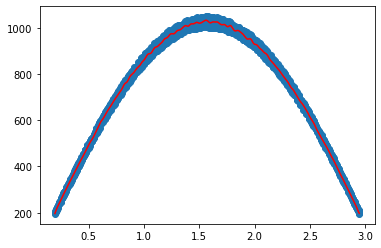

In [18]:
plt.figure()
plt.scatter(t_test, r_test)
plt.plot(t_test, rtest_filtered, color='red')

Plotting the cartesian coordinates of the noisy and lowpass filtered values. 

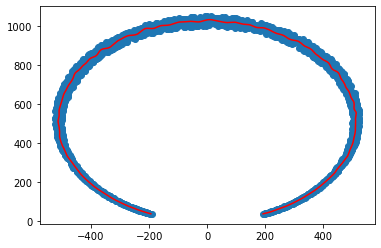

In [19]:
xcoords_test=r_test*np.cos(t_test)
ycoords_test=r_test*np.sin(t_test)

xcoords_test_lp=rtest_filtered*np.cos(t_test)
ycoords_test_lp=rtest_filtered*np.sin(t_test)

plt.figure()
plt.scatter(xcoords_test, ycoords_test)
plt.plot(xcoords_test_lp, ycoords_test_lp,color='red')

Regressed out coordinates, appropriate for computing distances. 

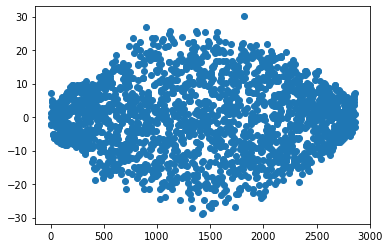

In [20]:

rtest_regout=r_test-rtest_filtered

dis_vec_test=rdistance_vec(rtest_filtered, t_test)
dis_vec_test=np.append(0, dis_vec_test)

plt.figure()
plt.scatter(dis_vec_test, rtest_regout)

As expected, distance values are distributed between $0$ and $1000* (\pi-\pi/8)$. Of course, we would need more precise and elaborate tests, but this test confirms algorithm's overall performance. 